In [3]:
sc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-0>

In [4]:
sc.install_pypi_package('pandas')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('seaborn')
sc.install_pypi_package('fsspec')
sc.install_pypi_package('s3fs')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1718278408708_0001/container_1718278408708_0001_01_000001/tmp/spark-53081e3b-8669-4733-b62f-a90062ff5fd9
    Can't uninstall 'python-dateutil'. No files were found to uninstall.





ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.





In [19]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import size
from pyspark.ml.evaluation import RegressionEvaluator


from pyspark.sql.functions import broadcast
from pyspark.sql.functions import col, avg, lit
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import (StringIndexer, VectorAssembler, VectorIndexer)
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
from pyspark.sql import SparkSession
spark = (SparkSession
     .builder
     .master('local[*]')
     .config('spark.sql.execution.arrow.pyspark.enabled', 'true')
     .getOrCreate())

HTML("""
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js"></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
<style>
    @import url('https://fonts.googleapis.com/css2?family=Montserrat:ital,wght@0,100..900;1,100..900&display=swap');
    
    body {
        font-weight: auto;
        font-family: Montserrat, sans-serif;
    }

    p {
        font-family: Montserrat, sans-serif;
    }

    h1, h2, h3{
        font-weight: 700;
        color: #e74646;
    }

    h4, h5, h6 {
        color: #d93e3e;
    }

    .toc {
      margin: 0 auto;
      width: 80%;
      column-count: 2;
      font-size: 1.2em;
      color: #bf2d2d;
    }
    
    .toc a:hover, .toc a:visited {
      color: #fa5e56;
    }
</style>
""")


![title](main.png)
<center><b>Image 1.</b> Title.</center>

<a name="top"></a>
<h2 style="font-weight: 700;">Table of Contents</h2>
<img src="decor.png">
<div class="toc">

[ref0]: #abs
[Abstract][ref0]

[ref1]: #prob
[Problem Statement][ref1]

[ref2]: #motiv
[Motivation][ref2]

[ref3]: #dat
[Data Source][ref3]

[ref5]: #metho
[Methodology][ref5]

[ref6]: #feature
[Feature Derivation][ref6]

[ref7]: #anomaly
[Outlier analysis][ref7]

[ref8]: #Baseline
[Setting a Baseline][ref8]

[ref9]: #train
[Training and Hypertuning Model][ref9]

[ref10]: #imp
[Feature importances][ref10]

[ref11]: #conc
[Conclusion][ref11]

[ref12]: #reco
[Recommendation][ref12]

[ref13]: #ref
[References][ref13]

[ref14]: #disclosure
[Disclosure][ref14]

</div>


<a name="abs"></a>
<h2>Abstract</h2>
<img src="decor.png">

This project embarked on a creation of a model that would.  predict the occupancy rates of Airbnb listings by leveraging machine learning techniques on preprocessed and feature-engineered data derived from two datasets: listings and reviews. Initially, feature derivation was performed to create actionable features such as average reviews per month, host experience, and average price per night. This was followed by filtering and preprocessing the raw data to eliminate extreme and impossible values, ensuring data integrity. Subsequently, outlier analysis was conducted to refine the dataset further.

A robust machine learning model was then trained to predict the occupancy rates, significantly outperforming the baseline model. The model's predictions were further analyzed to determine feature importance, offering valuable insights into the contributions of each feature to the occupancy rate. This analysis provides actionable intelligence for optimizing Airbnb listings, ultimately aiding hosts in improving their occupancy rates. The results underscore the efficacy of using advanced data processing and machine learning techniques in understanding and predicting occupancy trends in the short-term rental market.

<a name="prob"></a>
<h2>Problem statement</h2>
<img src="decor.png">


Ever since it's inception, Airbnb has seen exponential growth in it's business, with the number of listings going from less than 200,000 in 2016, to over 1 million in 2023 in the United States alone. The platform has become a lucrative venture for many property owners, giving them a chance to gain substantial passive income by renting out their living spaces. However, with this growth have come problems. Market saturation over the years has led to much lower occupancy rates for many, and with such a vast variety of potential reasons, it is getting tougher for the owners to stay competitive in today's market.$^{[1]}$

Given this context, the aim of this project is to develop a machine learning model that predicts Airbnb occupancy rates by leveraging data from Airbnb listings and reviews. By identifying key features that influence occupancy, the model can provide actionable insights for hosts to optimize their listings, improve guest satisfaction, and ultimately increase their occupancy rates. This study also aims to highlight the most important factors contributing to occupancy variations, helping hosts to make data-driven decisions and enhance their rental strategies, in turn helping the company generate more revenue.

<a name="motiv"></a>
<h2>Motivation</h2>
<img src="decor.png">



Airbnb has become a powerhouse in the travel and accommodation industry, generating substantial revenue in 2023 of over 9 billion dollars. Even in 2024, the company surpassed it's previous year Q1 revenue and is on target to reach a new high for the financial year. $^{[2]}$  The company's impressive financial performance showcases its potential as a lucrative venture, both for the company and for property owners who list their spaces on the platform. With such a strong revenue base, it is clear that there are already significant opportunities for income generation.

Given this context, the authors saw an opportunity to tackle a prevalent problem within Airbnb's ecosystem—predicting and optimizing occupancy rates. By addressing this challenge, we aim to help property owners maximize their earnings and, in turn, contribute to Airbnb's overall profitability. Understanding the factors that influence occupancy rates and leveraging advanced machine learning techniques to predict these rates can provide actionable insights for hosts. These insights will enable them to make data-driven decisions, ultimately enhance their revenue.

In essence, the motivation stems from the realization that improving occupancy rates not only benefits individual property owners but also strengthens Airbnb's market position, making it a win-win scenario. By solving this critical problem, the authors aim to contribute to the continued financial success and growth of Airbnb and its community of hosts.

<a name="dat"></a>
<h2>Data Source</h2>
<img src="decor.png">

<h3 style=" color: #d93e3e">Inside Airbnb Dataset</h3>


The datasets were pulled from the Asian Institute of Management's (AIM) public data directory. While the `insideairbnb` repository has multiple datasets, only two were used for this study. The `reviews` and the `listings` data for countries in europe and the USA were employed. The dataset is also  openly available on the inside airbnb website.


The Features per dataset and samples are as below:

### LISTINGS DATA

| Feature Name                        | Data Type |
|-------------------------------------|-----------|
| id                                  | Integer   |
| name                                | String    |
| host_id                             | Integer   |
| host_name                           | String    |
| neighbourhood_group                 | String    |
| neighbourhood                       | String    |
| latitude                            | Float     |
| longitude                           | Float     |
| room_type                           | String    |
| price                               | Float     |
| minimum_nights                      | Integer   |
| number_of_reviews                   | Integer   |
| last_review                         | Date      |
| reviews_per_month                   | Float     |
| calculated_host_listings_count      | Integer   |
| availability_365                    | Integer   |
| number_of_reviews_ltm               | Integer   |
| license                             | String    |
    
<center><b>Table 1.</b> Data description of the listings dataset.</center>
    

A sample of the dataset has been provided below:

In [9]:
import pandas as pd
spark.read.csv('/mnt/data/public/insideairbnb/data.insideairbnb.com/united-states/il/chicago/2018-05-18/visualisations/listings.csv'
               , header = True).limit(5).toPandas()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,Hyde Park-Walk to UChicago or Theological Semi...,2613,Rebecca,None,Hyde Park,41.78886490087766,-87.58670890962763,Private room,50,2,117,2018-05-14,2.86,1,195
1,4505,"One great apartment, 332 great reviews, 1 bad ...",5775,Craig & Kathleen,None,South Lawndale,41.854952624963666,-87.69696178980683,Entire home/apt,120,2,346,2018-05-10,3.09,1,184
2,6715,Lincoln Park Oasis - Unit 2 ONLY,15365,Reem,None,Lincoln Park,41.92926222112926,-87.66009125412157,Entire home/apt,255,4,85,2018-05-14,0.78,2,291
3,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,None,West Town,41.9028949379226,-87.68182159890866,Entire home/apt,80,2,287,2018-04-20,4.89,1,289
4,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,None,Lincoln Park,41.917689236120225,-87.63787943696494,Entire home/apt,150,3,19,2018-03-18,0.38,11,312


<center><b>DataFrame 1.</b>Sample of listings dataset</center>

### REVIEWS DATA

| Feature Name    | Data Type |
|-----------------|-----------|
| listing_id      | Integer   |
| id              | Integer   |
| date            | Date      |
| reviewer_id     | Integer   |
| reviewer_name   | String    |
| comments        | String    |
<center><b>Table 2.</b> Data description of the reviews dataset.</center>

A sample of the dataset has been provided below:


In [10]:
import pandas as pd
spark.read.csv('/mnt/data/public/insideairbnb/data.insideairbnb.com/united-states/il/chicago/2018-05-18/data/reviews.csv.gz'
               , header = True).limit(5).toPandas()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2384,25218143,2015-01-09,14385014,Ivan,it's a wonderful trip experience. I didn't exc...
1,2384,28475392,2015-03-24,16241178,Namhaitou,This is my first trip using Airbnb. I was a li...
2,2384,30273263,2015-04-19,26101401,Patrick,The reservation was canceled 80 days before ar...
3,2384,30974202,2015-04-30,26247321,Cristina,Sólo puedo decir cosas buenas de Rebecca. La h...
4,2384,31363208,2015-05-04,31293837,SuJung,Rebecca was an absolutely wonderful host.


<center><b>DataFrame 2.</b> Sample of reviews dataset.</center>

The study uses 3 parquet files as the data processed, hence in order to get the size out, the three were placed in a folder and their size was outputed. The total processed data amount to approximately 86GB, which is above the required 50GB for the study mandates.
<img src="size.png">
<center><b>Image 2.</b> Data size.</center>

Proof of them being in the bucket has been provided below:
<img src="proof.png">
<center><b>Image 3.</b> Proof of file.</center>

Image of instance types
<img src="instance.png">
<center><b>Image 4.</b> instances tab.</center>

<a name="metho"></a>
<h2>Methodology</h2>
<img src="decor.png">
<img src="Meth.png">
<center><b>Image 5.</b> Methodology.</center>


<a name="feature"></a>
<h2>Feature Derivation</h2>
<img src="decor.png">

***

Initially, it was clear that many of the available features were either irrelevant or insufficient on their own, requiring additional context or external data to become actionable. This realization led to a feature derivation process, where existing features were transformed and combined to create more insightful and predictive variables for the ML model.

The derived features are as follows:

| Feature                | Description                                                                                                      | Data Type | Formula |
|------------------------|------------------------------------------------------------------------------------------------------------------|-----------|---------|
| `listing_id`           | Unique identifier for an Airbnb listing. Serves as the key feature for merging datasets.                         | double    | N/A     |
| `avg_reviews_per_month`| Average number of reviews per month for a listing across all active periods.                                      | double    | `mean('reviews_per_month')` |
| `host_experience`      | Calculated as total reviews divided by total listings for an ID, indicating host engagement and guest feedback.  | double    | `col('total_reviews') / col('total_host_listings_count')` |
| `average_nights`       | Average minimum number of nights a guest must stay, based on host settings.                                       | double    | `col('total_minimum_nights') / col('total_host_listings_count')` |
| `avg_price`            | Average price per listing ID.                                                                                    | double    | `mean('price')` |
| `avg_price_per_night`  | Average of price divided by minimum number of nights, providing nightly charge insights.                         | double    | `col('price') / col('minimum_nights')` |
| `occupancy`            | Target variable derived from `availability_365`, indicating occupancy rate over a 365-day period.                | double    | `1 - (col('availability_365') / 365)` |
| `avg_len_reviews`      | Average length of reviews for each listing, offering insight into the typical amount of feedback from guests.    | double    | `F.mean(F.length('comments'))` |


<center><b>Table 3.</b> Data description of the derived features from listings and reviews data.</center>



***Note*** - The dataframes were combined further down the pipeline to ensure reduction in run time.

In [4]:
listings_df = spark.read.parquet('s3://bigdatabucket25/e-M1KJBZ3J7W2M8EV089382575/listings.parquet')
df_reviews = spark.read.parquet('s3://bigdatabucket25/e-M1KJBZ3J7W2M8EV089382575/reviews.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
listings_df =listings_df.withColumn('occupancy_days',
                                    1- (col('availability_365')/365))
listings_df =listings_df.withColumn('price_per_night',
                                    col('price')/ col('minimum_nights'))
aggregated_df = listings_df.groupby('id').agg(
    F.collect_set('room_type').alias('room_types'),
    F.sum('number_of_reviews').alias('total_reviews'),
    F.mean('reviews_per_month').alias('avg_reviews_per_month'),
    F.sum('calculated_host_listings_count').alias('total_host_listings_count'),
    F.sum('minimum_nights').alias('total_minimum_nights'),
    F.mean('occupancy_days').alias('occupancy'),
    F.mean('price_per_night').alias('avg_price_per_night'),
    F.mean('price').alias('avg_price')).persist()

aggregated_df = aggregated_df.withColumn('average_nights', 
                                         col('total_minimum_nights') / col('total_host_listings_count'))
aggregated_df = aggregated_df.withColumn('host_experience', 
                                         col('total_reviews') / col('total_host_listings_count')
                                        ).withColumnRenamed('id','listing_id')
aggregated_df = aggregated_df.dropna(how = 'any')
aggregated_df = aggregated_df.persist()


df_reviews = df_reviews.na.fill('None')
tokenizer = Tokenizer(inputCol="comments", outputCol="words")
wordsData = tokenizer.transform(df_reviews)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
words_removed = remover.transform(wordsData)
words_removed = words_removed.withColumn('len', size(col('filtered_words')))
words_removed = words_removed.groupby('listing_id').agg({'len':'mean'}
                ).withColumnRenamed( 'avg(len)', 'avg_len_reviews'
                                    ).select('listing_id', 'avg_len_reviews').persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<a name="met"></a>
<h2>Data Exploration and Preprocessing</h2>
<img src="decor.png">

***




During the initial exploratory data analysis (EDA), several graphs and visualizations revealed some unexpected and unusual patterns. On further investigation, the authors identified that certain features contained extreme or impossible values, which needed to be addressed to ensure data quality and model accuracy.

For example, the `avg_price` feature exhibited some negative values, which are clearly unrealistic for a pricing attribute. Such anomalies necessitated a thorough cleaning and preprocessing step to remove outliers and erroneous data points.

Key steps taken during EDA and preprocessing included:

- **Filtering Extreme Values:** Features with extreme values that were beyond reasonable limits were also scrutinized. This included setting logical bounds for features like `average_nights` to ensure they fell within a plausible range.
- **Handling Missing Data:** Missing values were addressed through imputation methods or by removing records with significant missing information.

Through these steps, the data was cleaned and preprocessed to better reflect realistic scenarios and improve the robustness of the predictive model. Following the filtering, proper EDA was performed

---

In [6]:
from pyspark.sql.functions import col

agg_df = aggregated_df.filter(
    (col('occupancy') <= 1) &
    (col('occupancy') > 0) &
    (col('average_nights') > 0) &
    (col('average_nights') <= 365) &
    (col('avg_price') < 1500) &
    (col('avg_price')>0)&
    (col('average_nights') >0) &
    (col('average_nights') <=40)&
    (col('avg_price_per_night') <=250)&
    (col('avg_price_per_night')>0)&
    (col('host_experience') >=0)&
    (col('host_experience')<100
    ))

df_ = agg_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

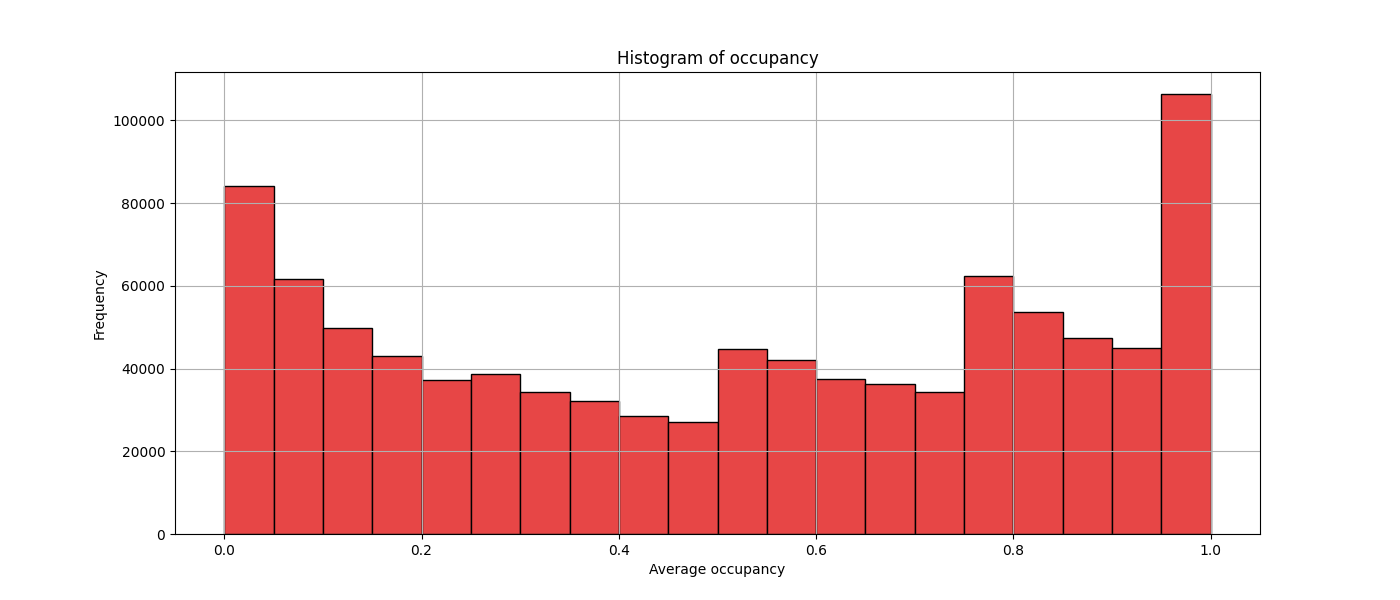

In [7]:
import matplotlib.pyplot as plt
plt.close()
plt.figure(figsize=(14, 6))
plt.hist(df_['occupancy'], bins=20, color='#E74646', edgecolor='black')

plt.xlabel('Average occupancy')
plt.ylabel('Frequency')
plt.title('Histogram of occupancy')
plt.grid(True)
plt.show()
%matplot plt

<center><b>Visual 1.</b> occupancy rating spread.</center>

The figure above illustrates the distribution of occupancy ratings. Ideally, the majority of the ratings would cluster around the center of the graph, indicating a balanced spread. However, in this case, the highest frequencies are observed at the extreme ends of the graph. 

There are two potential reasons for occupancy ratings to be on the extreme ends:
1. The data has been imputed incorrectly 
2. These are ***fake listings*** - such listings are made in order to attract customers, take thier money and never actually offer them a place to live$^{[3]}$ 

This unusual pattern provided further motivation to conduct a comprehensive outlier analysis on the occupancy feature to better understand and address these anomalies, which will be showcased in the next segment.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

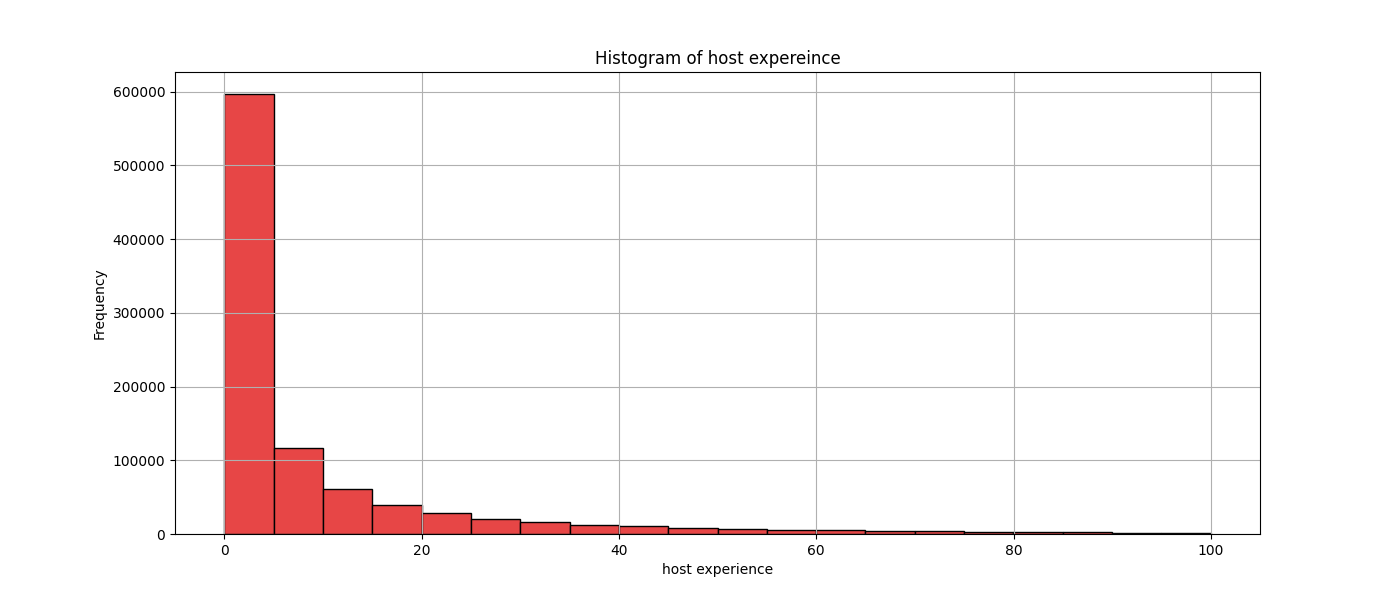

In [8]:
import matplotlib.pyplot as plt
plt.close()
plt.figure(figsize=(14, 6))
plt.hist(df_['host_experience'], bins=20, color='#E74646', edgecolor='black')

plt.xlabel('host experience')
plt.ylabel('Frequency')
plt.title('Histogram of host expereince')
plt.grid(True)
plt.show()
%matplot plt

<center><b>visual 2.</b> host experience rating spread.</center>

Unlike the previous visual, the host experience does not show any anmalites, indicating no need for outlier analysis.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

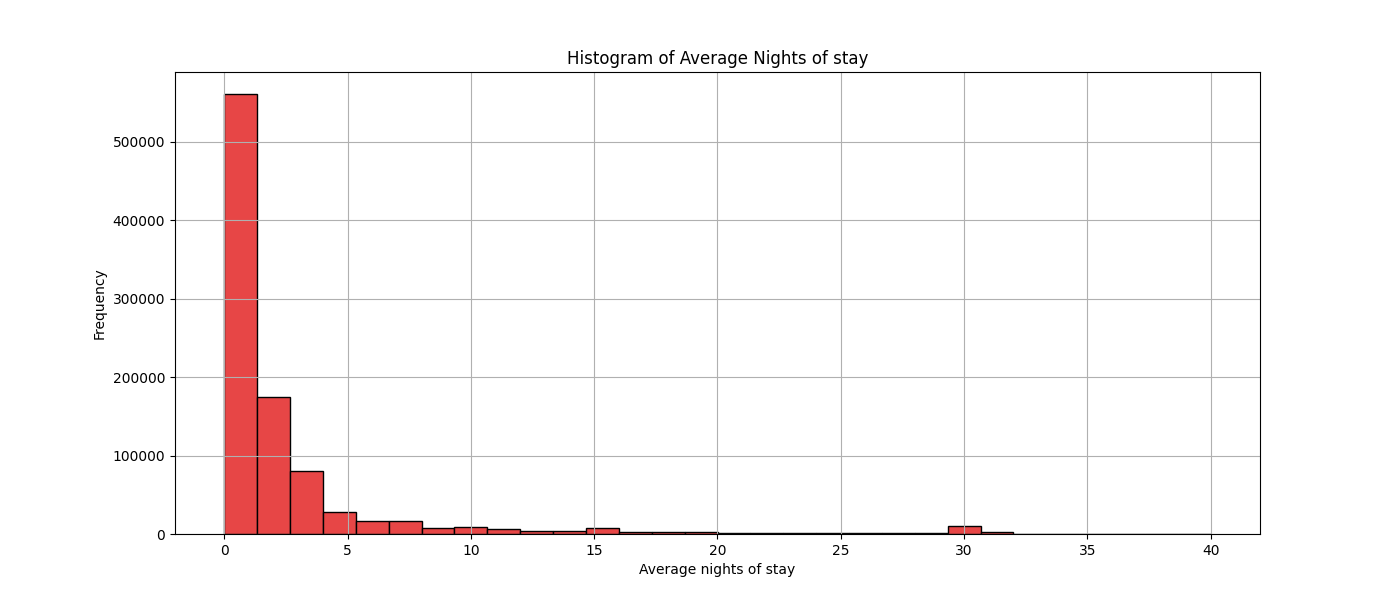

In [9]:
import matplotlib.pyplot as plt
plt.close()
plt.figure(figsize=(14, 6))
plt.hist(df_['average_nights'],bins = 30,  color='#E74646', edgecolor='black')
plt.xlabel('Average nights of stay')
plt.ylabel('Frequency')
plt.title('Histogram of Average Nights of stay')
plt.grid(True)
plt.show()
%matplot plt

<center><b>visual 3.</b> Average nights of stay spread.</center>

The histogram of the average nights follows a right skewed behaviour and does not display anything out the ordinary.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

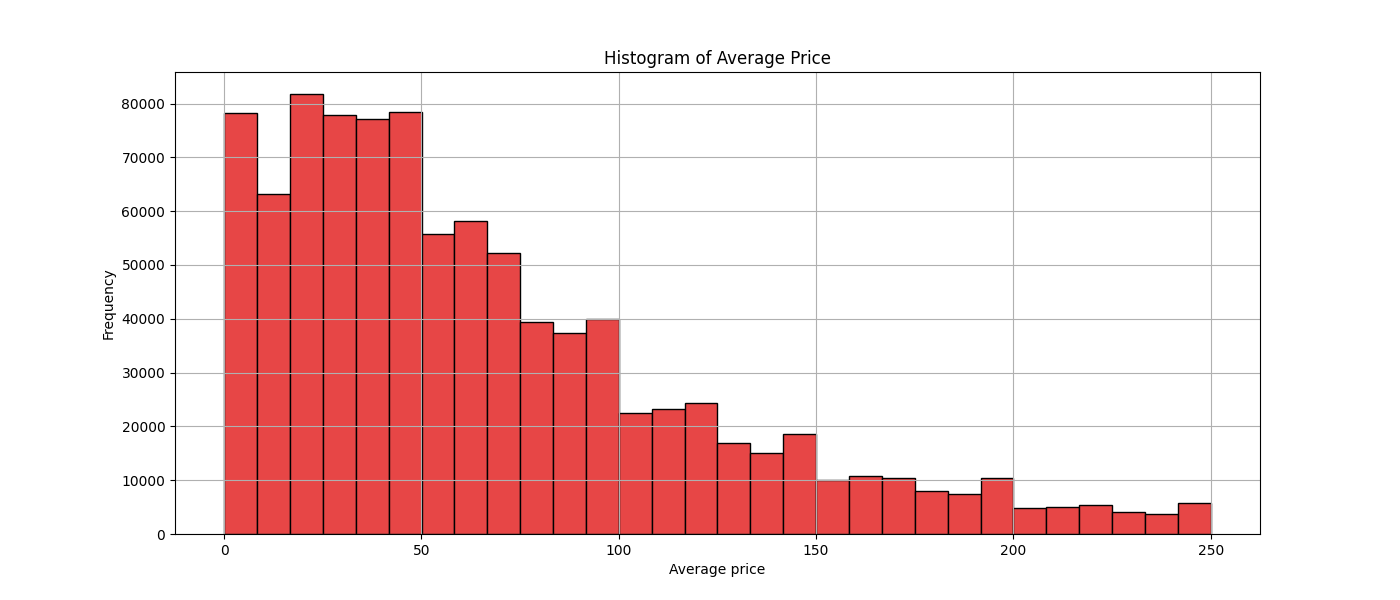

In [10]:
import matplotlib.pyplot as plt
plt.close()
plt.figure(figsize=(14, 6))
plt.hist(df_['avg_price_per_night'],bins = 30,  color='#E74646', edgecolor='black')

plt.xlabel('Average price')
plt.ylabel('Frequency')
plt.title('Histogram of Average Price')
plt.grid(True)
plt.show()
%matplot plt

<center><b>visual 4.</b> Average price spread.</center>

Similar to the visual of average nights, the average price too follows right skewed behaviour. Such behaviour is expected and since there aren't any anomalies being noticed, outlier analysis need not be done for this feature.

Following the insights gained from EDA, the authors then moved to conduct outlier analysis.

<a name="anomaly"></a>
<h2>Outlier Analysis</h2>
<img src="decor.png">


Outliers in the data can not only skew the model's prediction power but also hinder it's ability to extract feature importance. To ensure a more robust and accurate model, outlier removal was pivotal in the study's pipeline.

After delving into the insights extracted from the occupancy histogram, the authors proceeded with outlier analysis and subsequent removal. Initially experimenting with a `Gaussian Mixture Model`, they encountered challenges due to the absence of distinct clusters. Consequently, they turned to statistical methods for analysis. Calculating the standard deviation and mean for the features, they then computed `z-scores` to identify outliers. Leveraging this information, outliers were systematically eliminated, leading to the creation of a refined dataframe devoid of such anomalies. The threshold was computed by multiplying the standard deviation by a factor of 4

Once the outlier removal was completed, both the dataframes were joined using a `broadcast` join

In [11]:
mean_value = agg_df.agg(F.mean(col('occupancy')
                              ).alias('mean')).collect()[0]['mean']
stddev_value = agg_df.agg(F.stddev(col('occupancy')
                                  ).alias('stddev')).collect()[0]['stddev']
z_score_threshold = 1.4
df_filtered = agg_df.withColumn('z_score', (col('occupancy')
                                            - mean_value) / stddev_value) \
    .filter(col('z_score').between(-z_score_threshold
                                   , z_score_threshold))
broad = broadcast(df_filtered)
result_df_1 = words_removed.join(broad,on = 'listing_id', how = 'inner')
df_fil = df_filtered.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

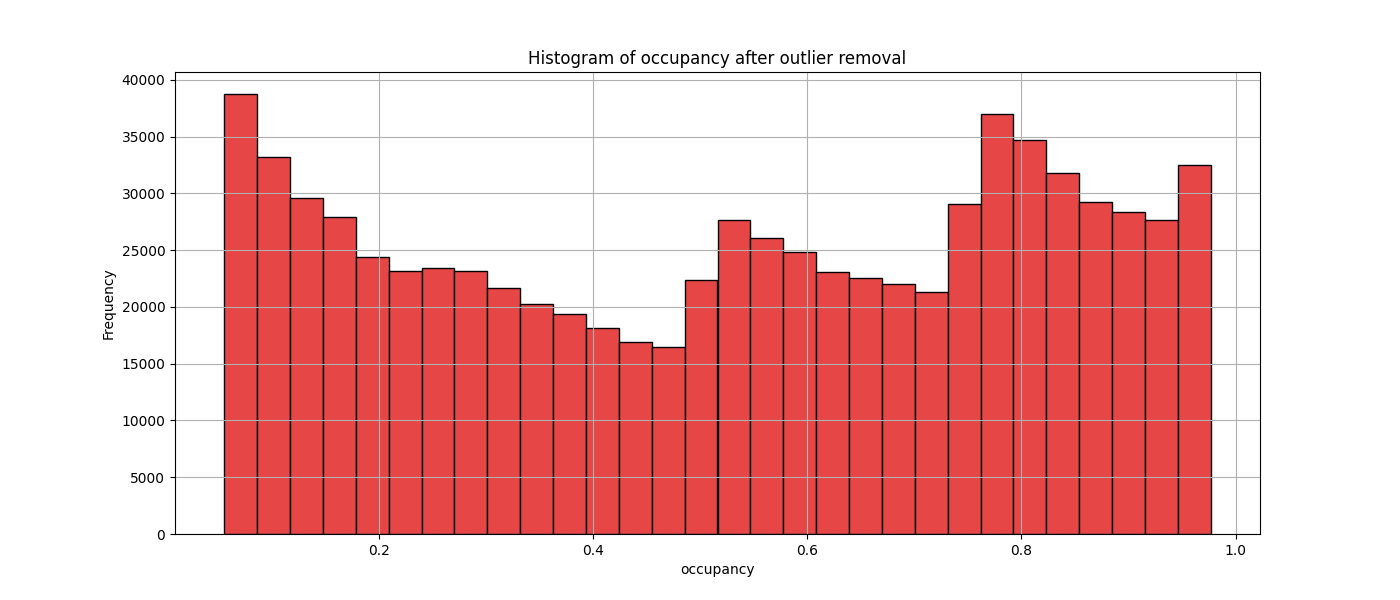

In [12]:
import matplotlib.pyplot as plt
plt.close()
plt.figure(figsize=(14, 6))
plt.hist(df_fil['occupancy'],bins = 30,  color='#E74646', edgecolor='black')

plt.xlabel('occupancy')
plt.ylabel('Frequency')
plt.title('Histogram of occupancy after outlier removal')
plt.grid(True)
plt.show()
%matplot plt

<center><b>visual 5.</b> Occupancy rating spread post outlier removal.</center>

Comparing `Visual 5` and `Visual 1`, it is evident that the application of the `z-score` method for outlier removal has effectively eliminated extreme outliers. This process has resulted in cleaner data, which is more suitable for model development.

<a name="Baseline"></a>
<h2>Setting a Baseline</h2>
<img src="decor.png">

To establish a benchmark for evaluating the model results, a baseline was created. This baseline serves as a point of comparison to understand the effectiveness and accuracy of the predictive model. The baseline was constructed by calculating the mean of the target column, which represents the average value of the target variable across all data points. This mean value was then used as the prediction for all listings, regardless of their individual features or characteristics.

By adopting the mean of the target column as the predicted rating for each listing, a simplistic yet effective baseline model was formulated. This approach assumes that the best prediction one could make without any additional information is the average value. While rudimentary, this method provides a useful benchmark against which more sophisticated models can be measured.

Subsequently, the Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) were calculated for this baseline model. These metrics quantify the prediction errors by comparing the baseline predictions to the actual target values. RMSE provides a measure of the average magnitude of the errors, giving higher weight to larger errors, while MAE offers a straightforward average of absolute errors, treating all errors equally.

The resulting RMSE and MAE values from the baseline model serve as crucial benchmarks. They provide a clear indication of the minimum performance level that any developed model should surpass. 

The results are as below:

| Baseline |        MAE        |        RMSE        |
|----------|--------------------|---------------------|
|   Value  | 0.32 | 0.41 |

<center><b>Table 6.</b> Baseline mae and rmse</center>

In [13]:
mean = df_filtered.select(avg('occupancy')).first()[0]
from pyspark.sql.functions import lit
df_baseline = df_filtered.withColumn('baseline', lit(mean))
df_baseline = df_baseline.dropna(how = 'any')
#list = ['mae', 'rmse']
eval_ = RegressionEvaluator(predictionCol = 'baseline',
                                         labelCol = 'occupancy',
                                         metricName = 'mae')
eval_r = RegressionEvaluator(predictionCol = 'baseline',
                                         labelCol = 'occupancy',
                                         metricName = 'rmse')
mae = eval_.evaluate(df_baseline)
rmse = eval_r.evaluate(df_baseline)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<a name="train"></a>
<h2>Training and Hypertuning Model</h2>
<img src="decor.png">



Once the data was fully aggregated and filtered, the final feature columns were selected, and a subsequent Parquet file was created to mitigate memory and run-time issues. This parquet file contains the joined version of the listings and reviews dataset. The parquet files contains two columns, one of the vector assembled features column and the other of the target. The columns used for this were the features and target for the model training, they are as below:

| features                                              | occupancy |
|-------------------------------------------------------|-----------|
| [19.43299711815562, 7.191483516483516, 4.14328...    | 0.089463  |
| [20.180174563591024, 84.0592261904762, 80.2, 4...    | 0.653082  |
| [29.503496503496503, 10.115857142857143, 22.86...    | 0.330137  |
| [14.528338927237034, 65.0, 98.68125, 8.5187755...    | 0.059603  |
| [23.654019873532068, 12.631608422939069, 4.865...    | 0.194082  |
<center><b>Table 7.</b> Dataframe for ML model training</center>

---


The features used in the final model were:
| Feature Name            |                                         
|-------------------------|
| avg_len_reviews         |
| avg_price_per_night     | 
| host_experience         | 
| avg_reviews_per_month   |
| average_nights          | 
<center><b>Table 8.</b> Features for model training</center>

This Parquet file was then reloaded, providing a streamlined and efficient dataset for further analysis. A CrossValidator was then established to fine-tune the machine learning model. The components of the CrossValidator included:

1. Model - `RandomForest Regressor` model with the target column as `occupancy`
2. evaluator = `RegressionEvaluator` with metrics `rmse` and `mae`

3. parameter grid - `max depth` of 2 - 10 and `number of trees` 30-50

4. Number of folds - `3` to ensure that the model does not overfit

The use of a CrossValidator ensures that the model is trained and validated across multiple subsets of the data, providing a comprehensive assessment of its performance and aiding in the selection of the best hyperparameters for optimal prediction accuracy. With the cross validator in place, the data was split into a 70-30 train/test split and subsequent model training was conducted.

The results of the best model were:

| Hypertuned RF model |        MAE        |        RMSE        |
|----------|--------------------|---------------------|
|   Value  | 0.23 | 0.27 |
<center><b>Table 9.</b> Best model results</center>

In [6]:
spark.read.parquet('s3://bigdatabucket25/e-M1KJBZ3J7W2M8EV089382575/ML.parquet').limit(5).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                            features  occupancy
0  [19.43299711815562, 7.191483516483516, 4.14328...   0.089463
1  [20.180174563591024, 84.0592261904762, 80.2, 4...   0.653082
2  [29.503496503496503, 10.115857142857143, 22.86...   0.330137
3  [14.528338927237034, 65.0, 98.68125, 8.5187755...   0.059603
4  [23.654019873532068, 12.631608422939069, 4.865...   0.194082

In [7]:
df_final = spark.read.parquet('s3://bigdatabucket25/e-M1KJBZ3J7W2M8EV089382575/ML.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:

rf = RandomForestRegressor(featuresCol = 'features',
                                     labelCol = 'occupancy')
evaluator = RegressionEvaluator(labelCol='occupancy', metricName='rmse')
param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 10]) \
    .addGrid(rf.numTrees, [10, 50]) \
    .build()
cross_val = CrossValidator(estimator=rf,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=3)
train, test = df_final.randomSplit([0.7, 0.3])
del df_final

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
test_mod = cross_val.fit(train)
preds = test_mod.transform(test)
eval_ = RegressionEvaluator(predictionCol = 'prediction',
                                         labelCol = 'occupancy',
                                         metricName = 'mae')
eval_r = RegressionEvaluator(predictionCol = 'prediction',
                                         labelCol = 'occupancy',
                                         metricName = 'rmse')
mae = eval_.evaluate(preds)
rmse = eval_r.evaluate(preds)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-9:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


In [12]:
print(mae, rmse)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-12:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


0.2376395376692768 0.2737318114096607

<a name="imp"></a>
<h2>Feature importances</h2>
<img src="decor.png">

After finalizing the model training phase and selecting the optimal model, the researchers proceeded to extract the feature importances. This critical step aimed to unveil the underlying factors influencing the model's predictions, thereby facilitating a deeper comprehension of the decision-making process. By deciphering what precisely drives the model's predictions, valuable insights were gleaned, enabling the identification of actionable strategies to assist hosts effectively.

While storing the parquet file, the columns were stored in this order:

1. Average price per night
2. Average len of reviews
3. Minimum nights stay
4. Average reviews per month
5. Host experience

The feature importance was then mapped to the number on the index of the result.

The ***top 3*** features were:



| Feature |        MAE        |  
|----------|--------------------|
|   Host experience  | 33% |
|Average price per night|18%|
|Minimum nights stay|19%|
<center><b>Table 9.</b> Top three predictors</center>

Mapping the features back to their formula, it can be notcied that all of these features are actionable and are aspects hosts can alter to change their occupancy

In [11]:
best_rf_model = test_mod.bestModel
importances = best_rf_model.featureImportances
importances

VBox()

Exception in thread cell_monitor-10:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-11:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


SparseVector(5, {0: 0.1876, 1: 0.1773, 2: 0.1905, 3: 0.1187, 4: 0.3258})

<a name="conc"></a>
<h2>Conclusion</h2>
<img src="decor.png">


| Model |        MAE        |        RMSE        |
|----------|--------------------|---------------------|
|   Baseline  | 0.32 | 0.41 |
|Our model|0.23|0.27|
<center><b>Table 10.</b> Model Comparison</center>

1. Comparing the two above, the authors successfully developed a model capable of predicting occupancy ratings with significantly greater accuracy than the baseline. Despite the lack on actionable features, features were derived and by rigorous forms of data pre processing and outlier removal, a robust Random Forest model was created.

2. By utilizing the model, the authors were able to extract feature importances, providing valuable insights into the primary factors influencing occupancy ratings. This analysis revealed potential strategies for assisting hosts, demonstrating the practical applications and benefits of turning this model into a real-world product.

<a name="reco"></a>
<h2>Recommendations</h2>
<img src="decor.png">


1. **Expand Feature Set**: The study was conducted using a limited set of features. The authors believe that incorporating more relevant features, as well as features that complement the existing ones, could not only enhance model performance but also provide deeper insights into the factors influencing occupancy rates. A richer feature set could capture more nuances and improve predictive accuracy.

2. **Region-Wise Analysis**: The authors recommend conducting region-specific analyses. While this study encompassed listings from across the globe, it is evident that Airbnb properties vary significantly by location. Different regions have unique characteristics, such as types of accommodations, amenities, tourist attractions, and visitor demographics. By segregating the data into distinct regions, more accurate and region-specific ML models can be developed, offering personalized insights that could greatly benefit hosts by catering to their unique regional dynamics.

3. **Segregate by Room Types**: The study did not account for variations in room types due to encoding errors. The authors suggest conducting separate analyses based on room types. Recognizing the differences between various room categories could yield more precise results and actionable insights. Understanding the specific dynamics of each room type can help tailor strategies to optimize occupancy and enhance overall performance.

By addressing these recommendations, future research can build on the current study's findings to create more robust models and provide more targeted insights, ultimately helping Airbnb hosts maximize their occupancy rates and profitability.

<a name="ref"></a>
<h2>References</h2>
<img src="decor.png">

1. “Navigating the Airbnb Bust: A Comprehensive Guide to Seizing Opportunities! | IGMS.” IGMS, 29 Sept. 2023, www.igms.com/airbnb-bust/.

2. “Airbnb Revenue 2018-2023 | ABNB.” Macrotrends.net, 2018, www.macrotrends.net/stocks/charts/ABNB/airbnb/revenue.


3. Chloë Nannestad. “Airbnb Scams: The 5 Most Common Ones and How to Avoid Them.” Reader’s Digest, 24 Apr. 2021, www.rd.com/article/airbnb-scams/.

<a name="disclosure"></a>
<h2>Disclosure</h2>
<img src="decor.png">

1. Chatgpt was used to aid in writing this report
2. The project was done in AWS but report creation was done in jojie 